   Temperature   Humidity  Wind_Speed  Cloud_Cover     Pressure     Rain
0    23.720338  89.592641    7.335604    50.501694  1032.378759     rain
1    27.879734  46.489704    5.952484     4.990053   992.614190  no rain
2    25.069084  83.072843    1.371992    14.855784  1007.231620  no rain
3    23.622080  74.367758    7.050551    67.255282   982.632013     rain
4    20.591370  96.858822    4.643921    47.676444   980.825142  no rain
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Temperature  2500 non-null   float64
 1   Humidity     2500 non-null   float64
 2   Wind_Speed   2500 non-null   float64
 3   Cloud_Cover  2500 non-null   float64
 4   Pressure     2500 non-null   float64
 5   Rain         2500 non-null   object 
dtypes: float64(5), object(1)
memory usage: 117.3+ KB
None
Accuracy: 0.926
Precision: 0.8163265305955852
Recall: 0.58823

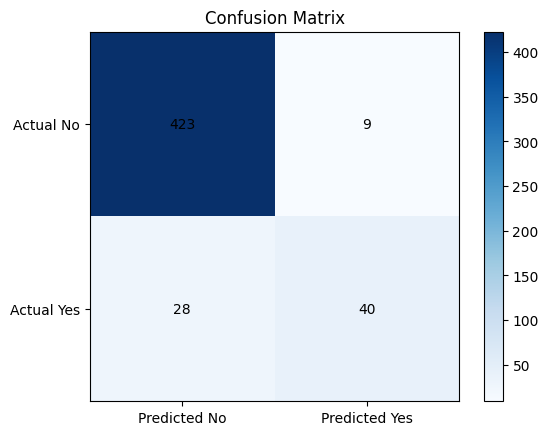

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("weather_forecast_data.csv")

print(df.head())
print(df.info())

# --- Preprocessing ---
# Convert target column "Rain" into binary (1 = rain, 0 = no rain)
df["Rain"] = df["Rain"].map({"rain": 1, "no rain": 0})

# Features and target
features = ["Temperature", "Humidity", "Wind_Speed", "Cloud_Cover", "Pressure"]
X = df[features].values
y = df["Rain"].values.reshape(-1, 1)

# Normalize features
X = (X - X.mean(axis=0)) / X.std(axis=0)

# Add bias term
X = np.c_[np.ones(X.shape[0]), X]

# Train-test split
np.random.seed(42)
indices = np.random.permutation(len(X))
train_size = int(0.8 * len(X))
train_idx, test_idx = indices[:train_size], indices[train_size:]
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

# --- Logistic Regression from Scratch ---
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def predict_probs(X, weights):
    return sigmoid(np.dot(X, weights))

def predict(X, weights, threshold=0.5):
    return (predict_probs(X, weights) >= threshold).astype(int)

def loss(y, y_pred):
    m = len(y)
    return -(1/m) * np.sum(y*np.log(y_pred+1e-9) + (1-y)*np.log(1-y_pred+1e-9))

def train_logistic_regression(X, y, lr=0.01, epochs=2000):
    weights = np.zeros((X.shape[1], 1))
    m = len(y)
    
    for _ in range(epochs):
        y_pred = predict_probs(X, weights)
        gradient = (1/m) * np.dot(X.T, (y_pred - y))
        weights -= lr * gradient
    return weights

# Train model
weights = train_logistic_regression(X_train, y_train, lr=0.01, epochs=5000)

# Predictions
y_pred_probs = predict_probs(X_test, weights)
y_pred = predict(X_test, weights)

# --- Manual Metrics ---
def confusion_matrix_manual(y_true, y_pred):
    TP = np.sum((y_true==1) & (y_pred==1))
    TN = np.sum((y_true==0) & (y_pred==0))
    FP = np.sum((y_true==0) & (y_pred==1))
    FN = np.sum((y_true==1) & (y_pred==0))
    return TP, TN, FP, FN

TP, TN, FP, FN = confusion_matrix_manual(y_test, y_pred)

accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP + 1e-9)
recall = TP / (TP + FN + 1e-9)
f1_score = 2 * (precision * recall) / (precision + recall + 1e-9)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

# --- Plot Confusion Matrix ---
cm = np.array([[TN, FP], [FN, TP]])
fig, ax = plt.subplots()
im = ax.imshow(cm, cmap="Blues")

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(["Predicted No", "Predicted Yes"])
ax.set_yticklabels(["Actual No", "Actual Yes"])

for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha="center", va="center", color="black")

plt.title("Confusion Matrix")
plt.colorbar(im)
plt.show()